# Dataset: **Civil Comments**

## Dataset Description

The **Civil Comments** dataset contains over 1.9 million public comments posted between 2015 and 2017 on the Civil Comments platform. After the platform closured, the data was annotated for toxicity-related attributes by a Google subsidiary, and split into train, test, and validation sets.

### Key Features:
- **text** (*string*): The original comment text.  
- **toxicity**, **severe_toxicity**, **obscene**, **threat**, **insult**, **identity_attack**, **sexual_explicit** (*float32*): Annotated toxicity scores (*not used in this study*).

As this is an **unsupervised learning** task, we focus exclusively on the comment text to uncover latent patterns in language and discourse.


## Project Objective

The main goal is to explore the **underlying structure** of online comments without using toxicity labels.  
We aim to group similar comments using **clustering algorithms** to discover distinct themes or topics in online discussion  

## Why ?

Understanding these patterns provides valuable insights for:

- **Moderation systems**: Identifying and acting on toxic or problematic topic patterns at a group level  
- **Social researchers**: Analyzing how and on what people communicate in online forums  
- **Platform design**: Informing better user experience and comment filtering

Uncovering natural clusters — without relying on predefined labels — opens the door to more flexible and adaptive tools for online communication analysis. The main challenge in this task is that online comment language is often informal, ambiguous, or sarcastic, which makes unsupervised structure discovery non-trivial.


In [45]:
#ismports

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from collections import Counter
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
import seaborn as sns


# required NLTK data (run once)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

# Import dataset

In [42]:
from datasets import load_dataset

ds = load_dataset("google/civil_comments")

# Data Cleaning Pipeline

To ensure good quality input for text clustering, we apply a rigorous preprocessing pipeline. Text clustering algorithms like KMeans or DBSCAN are highly sensitive to noisy, irrelevant, or inconsistent input — hence, preprocessing is essential. Also, since we decide to pick a base of only 10000 comments to not spend too long on training, we need to be extra vigourous in avoiding the noise.

## Why Preprocessing Matters

Short or trivial comments don't carry enough semantic information and can distort cluster formation so we set limits on how small or big a comment can be. We also remove URLs, email addresses, HTML tags, and special characters to avoid noise. Words like "the", "and", etc.. don't carry a lot of meaning and occur in almost every sentence so we remove them. We also noticed that some custom stopwords would imbalence the clustering too much when testing so we remove them. Finally, we also reduces words to their base form (lemmatization) to help groupe semantically similar tokens. 

## Cleaning Pipeline Steps

The pipeline is implemented in the following steps:

1. **Basic Cleaning**:  
   - Lowercasing  
   - Removing URLs, emails, HTML tags  
   - Removing non-alphabetical characters  
   - Expanding contractions (e.g., *won’t* → *will not*)
2. **Length Filtering**:  
   We retain only comments that:
   - Are between **100 and 1000 characters**  
   - Contain at least **10 words**
3. **Stopword Removal and Lemmatization**:  
   - Apply NLTK’s stopwords  
   - Add a domain-specific stopword list  
   - Tokenize and lemmatize using `WordNetLemmatizer`

In [53]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

def basic_clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\t\r]', ' ', text)
    text = re.sub(r"[^a-z\s']", '', text)
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
        "'m": " am", "'s": " is"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    text = re.sub(r"'", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def filter_by_length(texts, min_length=100, max_length=1000,  min_words=10):
    """Filter texts by character length"""
    return [text for text in texts if min_length <= len(text) <= max_length and len(text.split()) >= min_words]
    
def remove_stopwords_and_lemmatize(texts):
    """Remove stopwords and lemmatize using NLTK"""
    stop_words = set(stopwords.words('english'))
    custom_stopwords = set([
        "would", "like", "one", "people", "get", "think", "know", "time", "comment",
        "year", "want", "make", "really", "good", "great", "thing", "lot", "well",
        "say", "even", "also", "still", "much", "many", "see", "something",
        "article", "post", "posted", "posting", "response", "issue", "statement", "opinion", "fact",
        "work", "sure", "point", "thank", "thanks", "cool", "love",
        "person", "member", "someone", "anyone", "way", "right", "civil", "need", "read", "story", "life", "day", "mean", "new", "could", "take", "going"
    ])
    stop_words = stop_words.union(custom_stopwords)
    
    lemmatizer = WordNetLemmatizer()
    
    processed_texts = []
    
    for text in texts:
        tokens = word_tokenize(text)
        filtered_tokens = [
            lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in stop_words and len(token) > 2
        ]
        processed_texts.append(' '.join(filtered_tokens))
    
    return processed_texts

def clean_comments_pipeline(comments, min_length=50, max_length=1000, min_word_freq=3, min_words=5, verbose=True):
    print(f"Starting with {len(comments)} comments")
    
    cleaned = [basic_clean_text(comment) for comment in comments]
    cleaned = [c for c in cleaned if c]  # Remove empty strings
    print(f"After basic cleaning: {len(cleaned)} comments")
    
    length_filtered = filter_by_length(cleaned, min_length, max_length)
    print(f"After length filtering ({min_length}-{max_length} chars): {len(length_filtered)} comments")
    
    final_comments = remove_stopwords_and_lemmatize(length_filtered)
    print(f"Final dataset: {len(final_comments)} comments")
    
    return final_comments

def get_cleaning_stats(original_comments, cleaned_comments):
    stats = {
        'original_count': len(original_comments),
        'final_count': len(cleaned_comments),
        'retention_rate': len(cleaned_comments) / len(original_comments) * 100,
        'avg_length_original': sum(len(c) for c in original_comments) / len(original_comments),
        'avg_length_cleaned': sum(len(c) for c in cleaned_comments) / len(cleaned_comments),
        'avg_words_cleaned': sum(len(c.split()) for c in cleaned_comments) / len(cleaned_comments)
    }
    return stats

comments = ds["train"]["text"][:10000]

cleaned_comments = clean_comments_pipeline(comments)

stats = get_cleaning_stats(comments, cleaned_comments)
print("\nCleaning Statistics:")
for key, value in stats.items():
     print(f"{key}: {value:.2f}")

print("\nExample cleaned comments:")
for i, comment in enumerate(cleaned_comments[:3]):
    print(f"\nComment {i+1}:")
    print(comment[:200] + "..." if len(comment) > 200 else comment)

Starting with 10000 comments
After basic cleaning: 9989 comments
After length filtering (50-1000 chars): 8948 comments
Final dataset: 8948 comments

Cleaning Statistics:
original_count: 10000.00
final_count: 8948.00
retention_rate: 89.48
avg_length_original: 353.72
avg_length_cleaned: 217.31
avg_words_cleaned: 29.57

Example cleaned comments:

Comment 1:
mother idea done

Comment 2:
less anxietyinducing keep let

Comment 3:
urgent design problem kudos taking impressive


## Vectorization with TF-IDF

TF-IDF (Term Frequency–Inverse Document Frequency) transforms each comment into a sparse vector, where each dimension corresponds to a word. The value is higher for words that are important in a specific comment but rare in the overall corpus.

We will use TF-IDF as a baseline method for text representation.


In [50]:
def create_tfidf_vectors(texts, max_features=5000, min_df=2, max_df=0.8):
    print(f"Creating TF-IDF vectors with max_features={max_features}")
    
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=(1, 2),
        stop_words=None #already done
    )
    
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"Number of features: {len(feature_names)}")
    
    return tfidf_matrix, vectorizer, feature_names

def get_tfidf_stats(tfidf_matrix, feature_names, top_n=10):
    mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    top_indices = mean_scores.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], mean_scores[i]) for i in top_indices]
    
    stats = {
        'matrix_shape': tfidf_matrix.shape,
        'sparsity': 1 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])),
        'top_features': top_features
    }
    
    return stats

def print_tfidf_stats(stats):
    print(f"TF-IDF matrix shape: {stats['matrix_shape']}")
    print(f"Sparsity: {stats['sparsity']:.4f}")
    print("Top features:")
    for word, score in stats['top_features']:
        print(f"{word}: {score:.4f}")


tfidf_matrix, vectorizer, tfidf_features = create_tfidf_vectors(cleaned_comments)
tfidf_stats = get_tfidf_stats(tfidf_matrix, tfidf_features)
print_tfidf_stats(tfidf_stats)

Creating TF-IDF vectors with max_features=5000
TF-IDF matrix shape: (8948, 5000)
Number of features: 5000
TF-IDF matrix shape: (8948, 5000)
Sparsity: 0.9955
Top features:
oregon: 0.0097
state: 0.0096
money: 0.0089
year: 0.0087
going: 0.0086
city: 0.0086
school: 0.0079
public: 0.0079
tax: 0.0077
portland: 0.0076


## BERT Embeddings

To go beyond the limitations of TF-IDF, we will use BERT-based sentence embeddings (with Sentence Transformers) to capture the semantic meaning of comments, including context and word relationships.

This allows clustering methods to better identify comment types and topics, even when they use different wording.


In [54]:
# we use miniLM as it is fast and effective
def bert_embedding(comments, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(comments, show_progress_bar=True)
    return embeddings
    
bert_vectors = bert_embedding(cleaned_comments)


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

# Dimensionality Reduction

High-dimensional data (like TF-IDF vectors or BERT embeddings) can harm clustering performance due to the "curse of dimensionality". Dimensionality reduction techniques help compress data into a smaller, denser representation that preserves meaningful structure while reducing noise.

We use:
- **TruncatedSVD** for TF-IDF vectors (sparse input)
- **PCA** or **UMAP** for dense BERT embeddings

This step improves clustering quality, execution speed and visualization


In [61]:
from sklearn.decomposition import TruncatedSVD, PCA
import umap.umap_ as umap

def reduce_tfidf(tfidf_matrix, n_components=100):
    print(f"Reducing TF-IDF with TruncatedSVD to {n_components} dimensions")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    return svd.fit_transform(tfidf_matrix)

def reduce_bert_pca(embeddings, n_components=50):
    print(f"Reducing BERT embeddings with PCA to {n_components} dimensions")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(embeddings)

def reduce_bert_umap(embeddings, n_components=50, n_neighbors=15, min_dist=0.1):
    print(f"Reducing BERT embeddings with UMAP to {n_components} dimensions")
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric='cosine', random_state=42)
    return reducer.fit_transform(embeddings)

# TF-IDF reduction
reduced_tfidf = reduce_tfidf(tfidf_matrix, n_components=100)

# BERT reduction
reduced_bert = reduce_bert_pca(bert_embeddings, n_components=50)
reduced_bert_umap = reduce_bert_umap(bert_embeddings)



Reducing TF-IDF with TruncatedSVD to 100 dimensions
Reducing BERT embeddings with PCA to 50 dimensions
Reducing BERT embeddings with UMAP to 50 dimensions


/home/eugenie/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Clustering methods

## KMeans

We use the KMeans algorithm to group comments into clusters based on their content similarity. This is an unsupervised method that tries to partition the data into `k` clusters such that each comment belongs to the cluster with the nearest centroid.

We apply KMeans on two types of embeddings:

- **TF-IDF vectors**: sparse, high-dimensional, based on word frequency.
- **BERT embeddings**: dense, semantic vectors capturing meaning of full sentences.

We use the **Silhouette Score** to evaluate clustering quality. This score ranges from -1 to 1 and measures how well each point lies within its cluster compared to other clusters.


In [80]:
def perform_kmeans_clustering(X, k_range=(3, 10), metric_name="TF-IDF"):
    """Perform KMeans clustering with silhouette score evaluation"""
    best_score = -1
    best_k = None
    best_model = None
    scores = []
    
    print(f"Running KMeans on {metric_name} vectors...")
    print("-" * 40)
    
    for k in range(k_range[0], k_range[1]+1):
        model = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            scores.append((k, score))
            print(f"k={k}, silhouette score={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_k = k
                best_model = model
    
    print(f"\nBest K: {best_k}, Best silhouette score: {best_score:.4f}")
    return best_model, best_k, best_score, scores

# TF-IDF
#kmeans_tfidf, k_tfidf, score_tfidf = perform_kmeans_clustering(tfidf_matrix, k_range=(3, 10), metric_name="TF-IDF")

#BERT
#kmeans_bert, k_bert, score_bert = perform_kmeans_clustering(bert_vectors, k_range=(3, 10), metric_name="BERT")

#same but reduced dimensions
#kmeans_tfidf, k_tfidf, score_tfidf = perform_kmeans_clustering(reduced_tfidf, k_range=(3, 10), metric_name="TF-IDF")
#kmeans_bert, k_bert, score_bert = perform_kmeans_clustering(reduced_bert, k_range=(3, 10), metric_name="BERT (PCA)")
#kmeans_umap, k_umap, score_umap = perform_kmeans_clustering(reduced_bert_umap, k_range=(3, 10), metric_name="BERT (UMAP)")



# Visualisation/Evaluation

In [77]:
def visualize_clusters(vectors, cluster_labels, title, sample_size=1000):
    vectors_dense = vectors
    vectors_sample = vectors_dense
    labels_sample = cluster_labels
    
    # Apply PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors_sample)
    
    # Plot clusters
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels_sample)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:  # Noise points (DBSCAN)
            plt.scatter(vectors_2d[labels_sample == label, 0], 
                       vectors_2d[labels_sample == label, 1], 
                       c='black', marker='x', s=50, alpha=0.5, label='Noise')
        else:
            plt.scatter(vectors_2d[labels_sample == label, 0], 
                       vectors_2d[labels_sample == label, 1], 
                       c=[color], s=50, alpha=0.7, label=f'Cluster {label}')
    
    plt.title(f'{title}\nPCA Visualization (explained variance: {pca.explained_variance_ratio_.sum():.2%})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return pca

def analyze_cluster_content(texts, cluster_labels, vectorizer=None, top_words=10):
    unique_labels = np.unique(cluster_labels)
    print("= " * 5, "Cluster Analysis ", " =" * 5)
    cluster_info = {}
    
    for label in unique_labels:
        if label == -1:
            continue
            
        cluster_texts = [texts[i] for i in range(len(texts)) if cluster_labels[i] == label]
        cluster_size = len(cluster_texts)
        print(f"\nCluster {label} ({cluster_size} comments):")
        print("-" * 30)
        
        if vectorizer is not None:
            cluster_indices = [i for i in range(len(texts)) if cluster_labels[i] == label]
            if hasattr(vectorizer, 'transform'):
                cluster_tfidf = vectorizer.transform([texts[i] for i in cluster_indices])
                mean_scores = np.array(cluster_tfidf.mean(axis=0)).flatten()
                feature_names = vectorizer.get_feature_names_out()
                top_indices = mean_scores.argsort()[-top_words:][::-1]
                top_words_scores = [(feature_names[i], mean_scores[i]) for i in top_indices]
                print("Top words:")
                for word, score in top_words_scores:
                    print(f"  {word}: {score:.3f}")
                cluster_info[label] = {
                    'size': cluster_size,
                    'top_words': top_words_scores,
                    'sample_texts': cluster_texts[:3]
                }
    
    return cluster_info

def plot_silhouette_scores(scores_dict):
    plt.figure(figsize=(12, 6))
    
    for method_name, scores in scores_dict.items():
        k_values = [score[0] for score in scores]
        silhouette_values = [score[1] for score in scores]
        plt.plot(k_values, silhouette_values, marker='o', label=method_name)
    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def comprehensive_clustering_analysis(vectors_dict, texts, vectorizer=None, k_range=(3, 10)):
    results = {}
    all_scores = {}
    
    print("=" * 6, " Starting Comprehensive Clustering Analysis" , "=" * 6)
    # Perform clustering for each vector type
    for vector_name, vectors in vectors_dict.items():
        print(f"\nProcessing {vector_name}...")
        model, k, score, scores = perform_kmeans_clustering(vectors, k_range, vector_name)
        results[vector_name] = (model, k, score, scores)
        all_scores[vector_name] = scores

    plot_silhouette_scores(all_scores)
    
    print("\nGenerating Visualizations...")
    print("-" * 30)
    
    for vector_name, (model, k, score, scores) in results.items():
        vectors = vectors_dict[vector_name]
        labels = model.labels_
        
        pca = visualize_clusters(vectors, labels, f"{vector_name} Clustering (k={k})")
        
        if vectorizer is not None and "TF-IDF" in vector_name:
            cluster_info = analyze_cluster_content(texts, labels, vectorizer)
    
    return results

======  Starting Comprehensive Clustering Analysis ======

Processing TF-IDF...
Running KMeans on TF-IDF vectors...
----------------------------------------
k=3, silhouette score=0.0011
k=4, silhouette score=0.0019
k=5, silhouette score=0.0025
k=6, silhouette score=0.0028
k=7, silhouette score=0.0030
k=8, silhouette score=0.0034
k=9, silhouette score=0.0036
k=10, silhouette score=0.0042

Best K: 10, Best silhouette score: 0.0042

Processing BERT...
Running KMeans on BERT vectors...
----------------------------------------
k=3, silhouette score=0.0220
k=4, silhouette score=0.0205
k=5, silhouette score=0.0198
k=6, silhouette score=0.0203
k=7, silhouette score=0.0206
k=8, silhouette score=0.0195
k=9, silhouette score=0.0212
k=10, silhouette score=0.0199

Best K: 3, Best silhouette score: 0.0220

Processing TF-IDF (Reduced)...
Running KMeans on TF-IDF (Reduced) vectors...
----------------------------------------
k=3, silhouette score=0.0557
k=4, silhouette score=0.0594
k=5, silhouette scor

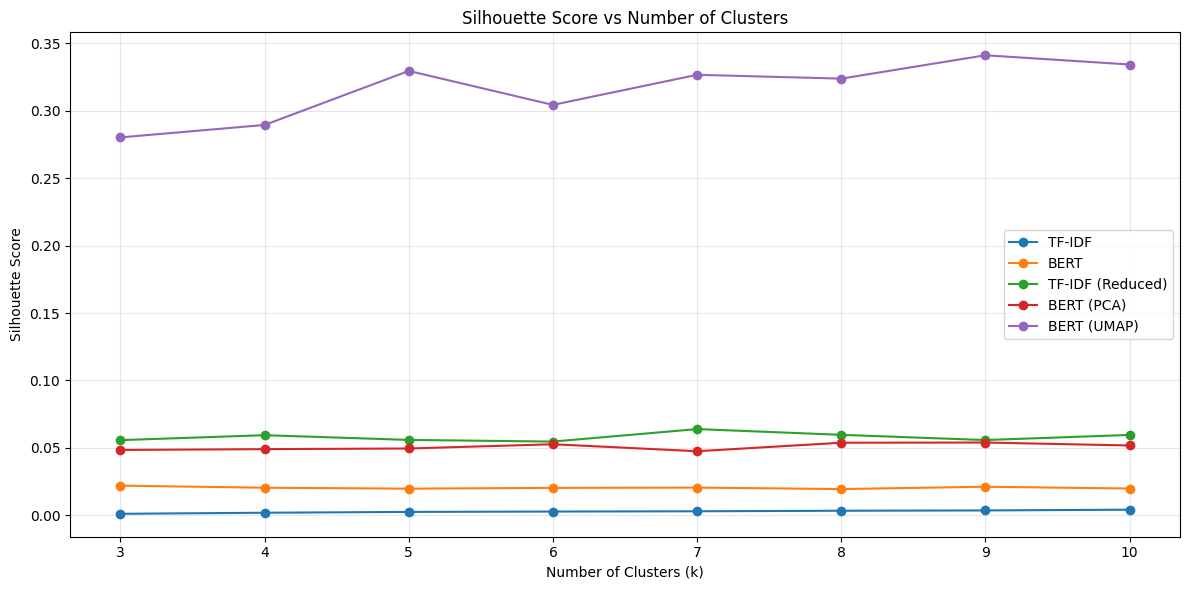


Generating Visualizations...
------------------------------


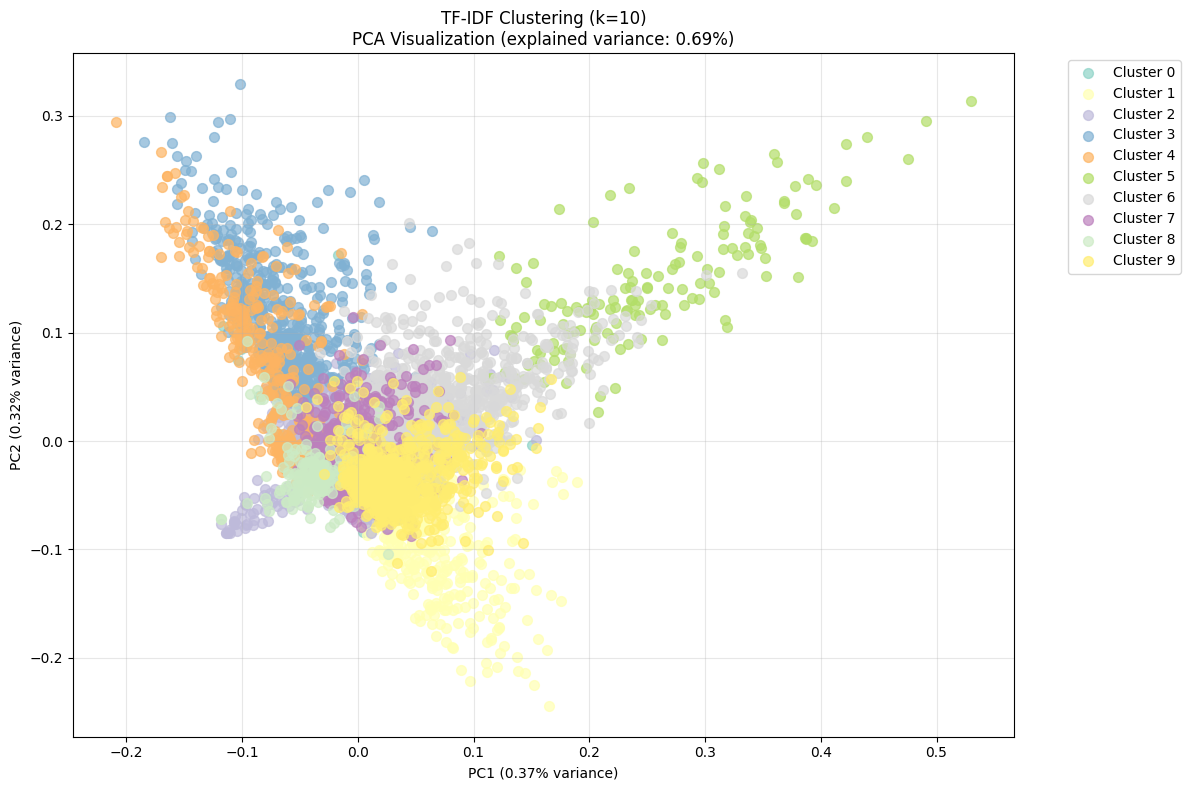

= = = = =  Cluster Analysis   = = = = =

Cluster 0 (128 comments):
------------------------------
Top words:
  sound: 0.243
  heard: 0.013
  weed: 0.013
  trying: 0.013
  ever: 0.011
  little: 0.011
  case: 0.011
  maybe: 0.010
  pretty: 0.010
  portland: 0.010

Cluster 1 (306 comments):
------------------------------
Top words:
  school: 0.188
  student: 0.107
  high school: 0.054
  high: 0.049
  kid: 0.048
  parent: 0.047
  teacher: 0.039
  education: 0.037
  child: 0.036
  class: 0.030

Cluster 2 (5001 comments):
------------------------------
Top words:
  year: 0.008
  never: 0.007
  may: 0.007
  actually: 0.007
  back: 0.007
  always: 0.006
  better: 0.006
  show: 0.006
  nothing: 0.006
  first: 0.006

Cluster 3 (563 comments):
------------------------------
Top words:
  vote: 0.072
  republican: 0.063
  president: 0.052
  party: 0.052
  democrat: 0.047
  obama: 0.044
  hillary: 0.043
  clinton: 0.035
  bernie: 0.028
  court: 0.028

Cluster 4 (366 comments):
----------------------

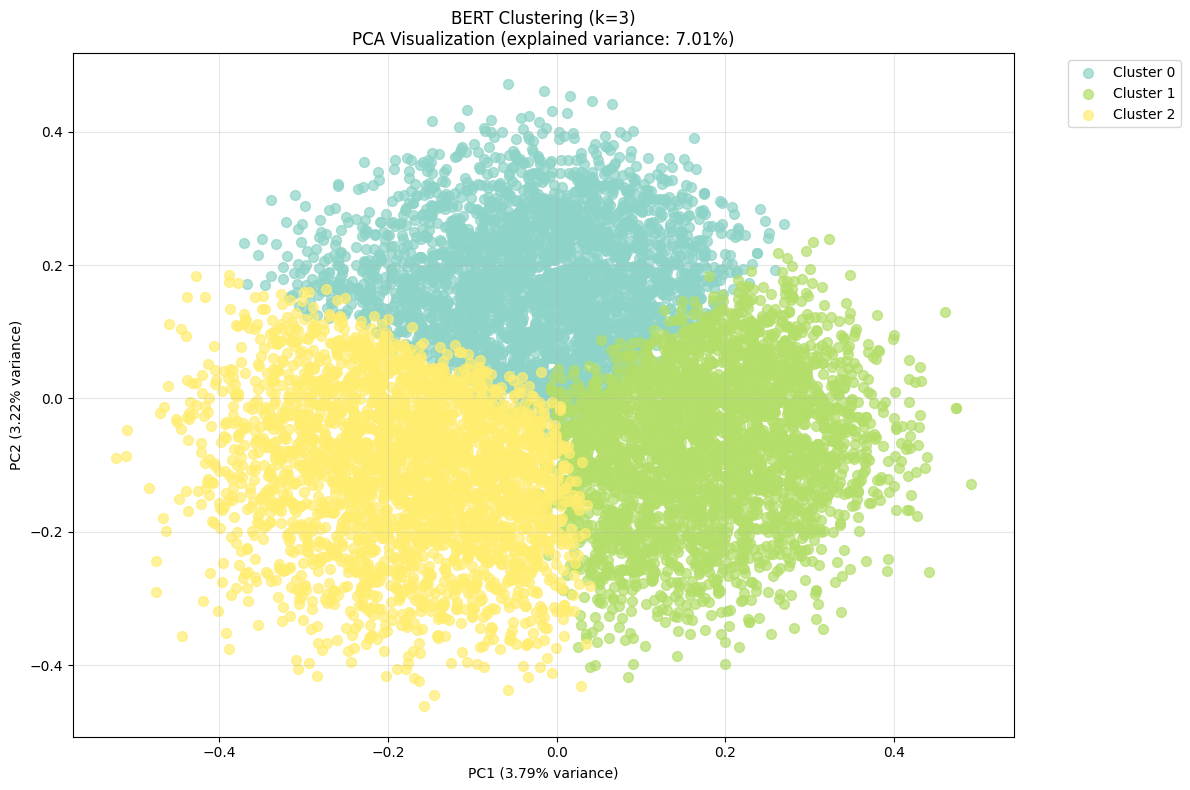

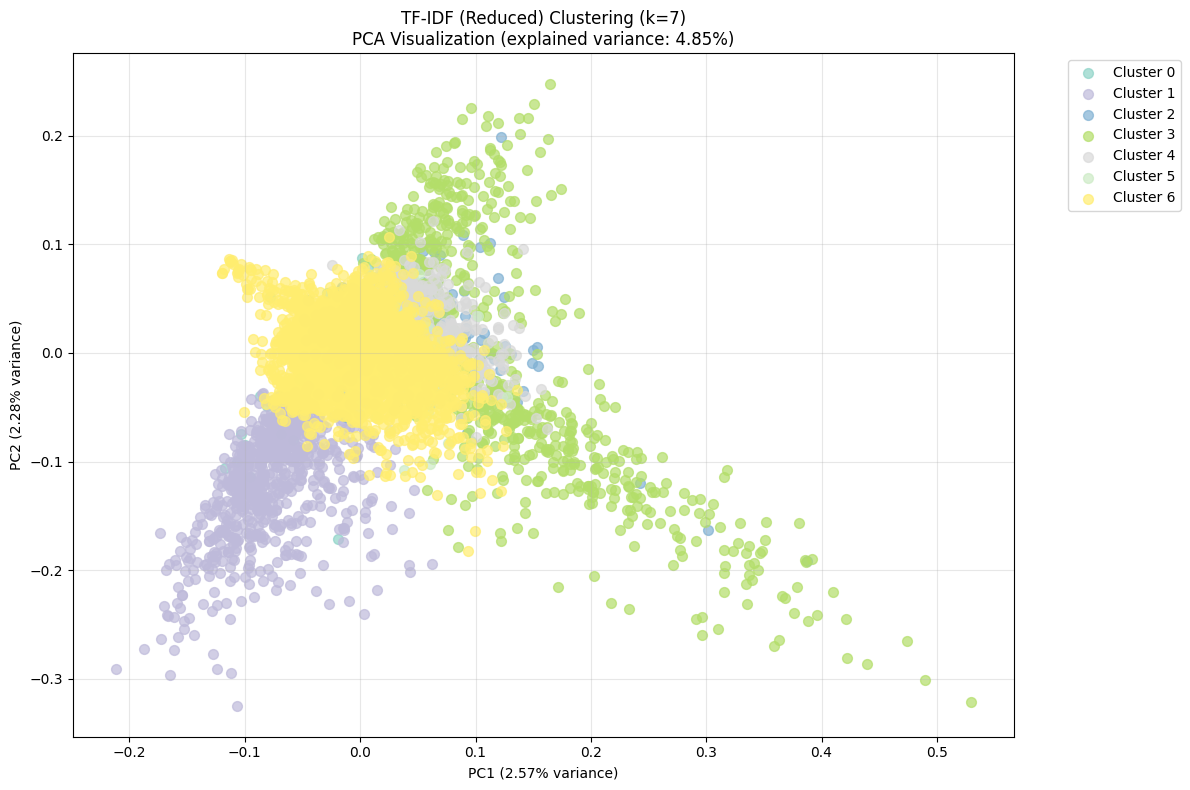

= = = = =  Cluster Analysis   = = = = =

Cluster 0 (122 comments):
------------------------------
Top words:
  sound: 0.247
  heard: 0.014
  weed: 0.014
  trying: 0.013
  case: 0.011
  information: 0.011
  ever: 0.011
  trump: 0.010
  thousand: 0.010
  maybe: 0.010

Cluster 1 (753 comments):
------------------------------
Top words:
  trump: 0.080
  vote: 0.053
  republican: 0.052
  president: 0.046
  party: 0.043
  hillary: 0.042
  obama: 0.038
  democrat: 0.037
  clinton: 0.032
  bernie: 0.027

Cluster 2 (226 comments):
------------------------------
Top words:
  portland: 0.240
  city: 0.036
  year: 0.020
  housing: 0.020
  living: 0.017
  public: 0.017
  oregon: 0.016
  tax: 0.014
  place: 0.012
  cost living: 0.011

Cluster 3 (701 comments):
------------------------------
Top words:
  school: 0.085
  tax: 0.060
  wage: 0.059
  student: 0.055
  pay: 0.038
  minimum: 0.037
  minimum wage: 0.035
  high: 0.028
  job: 0.027
  oregon: 0.027

Cluster 4 (688 comments):
-------------------

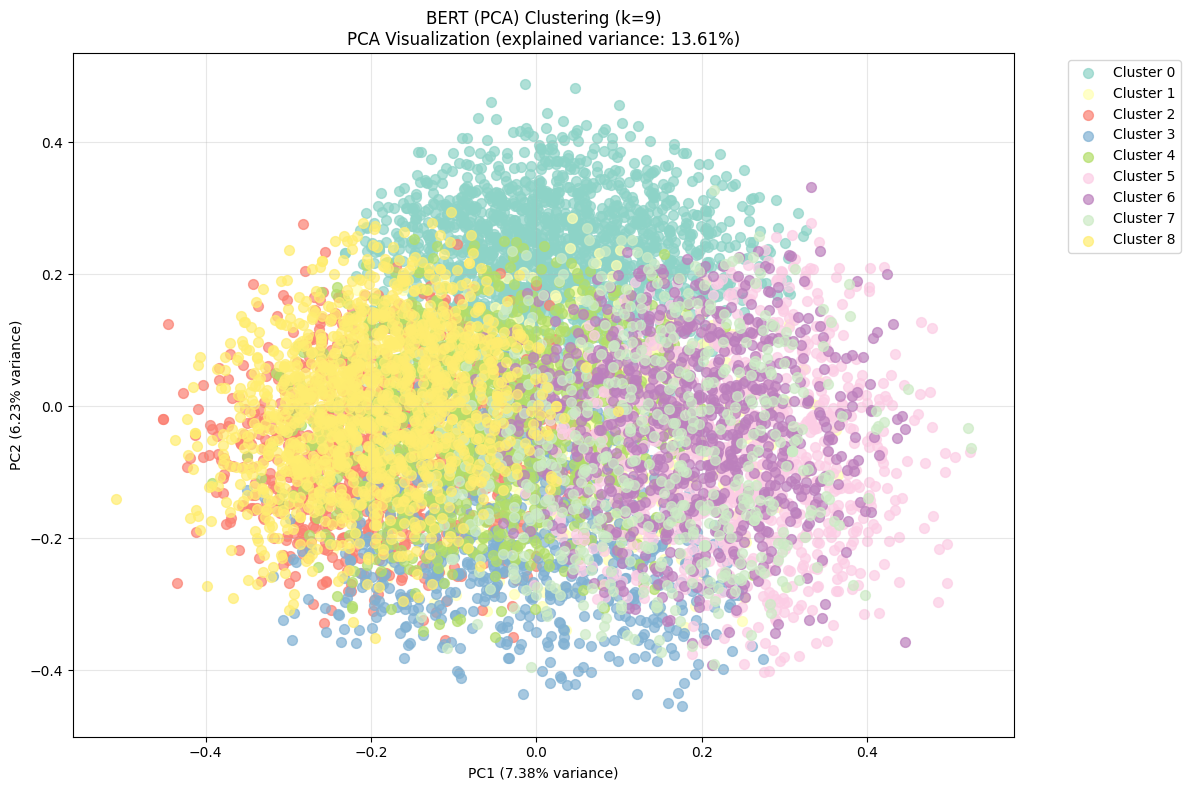

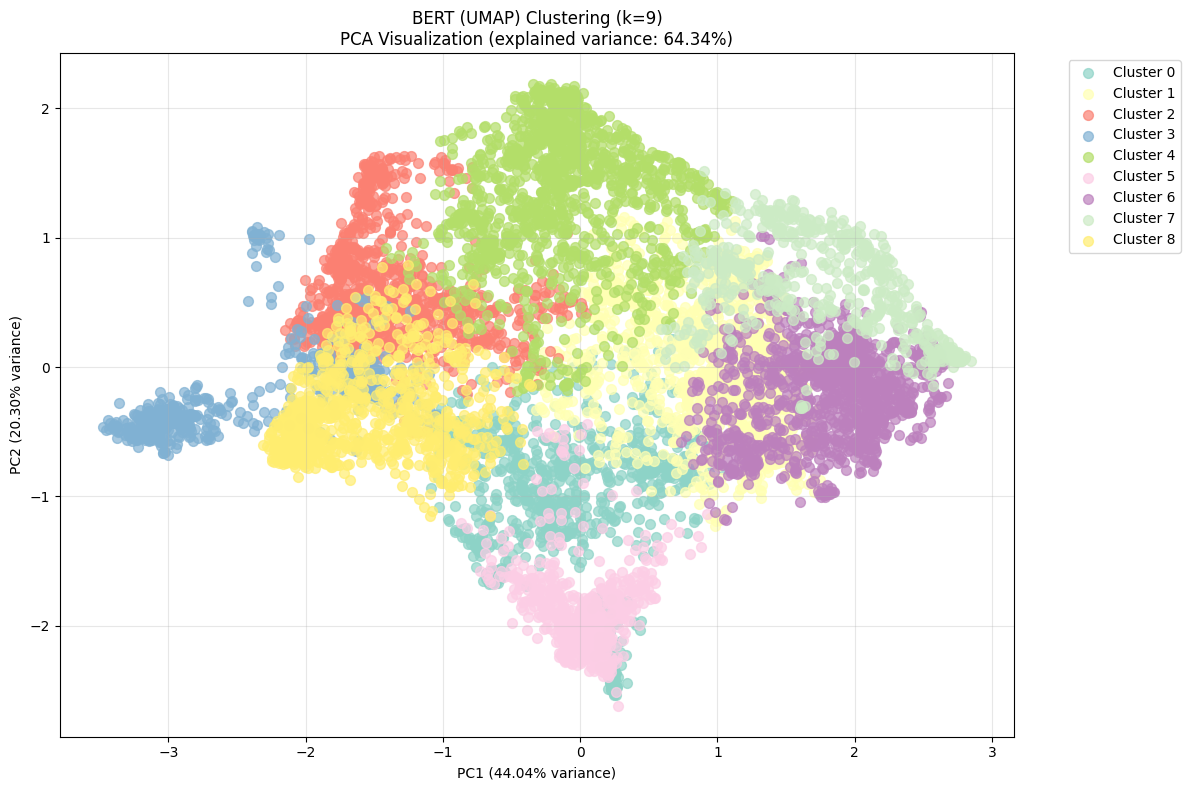

In [79]:

vectors_dict = {
    'TF-IDF': tfidf_matrix,
    'BERT': bert_vectors,
    'TF-IDF (Reduced)': reduced_tfidf,
    'BERT (PCA)': reduced_bert,
    'BERT (UMAP)': reduced_bert_umap
}

results = comprehensive_clustering_analysis(
    vectors_dict=vectors_dict,
    texts=cleaned_comments,
    vectorizer=vectorizer,
    k_range=(3, 10)
)